```
Licensed to the Apache Software Foundation (ASF) under one
or more contributor license agreements.  See the NOTICE file
distributed with this work for additional information
regarding copyright ownership.  The ASF licenses this file
to you under the Apache License, Version 2.0 (the
"License"); you may not use this file except in compliance
with the License.  You may obtain a copy of the License at
  http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing,
software distributed under the License is distributed on an
"AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
KIND, either express or implied.  See the License for the
specific language governing permissions and limitations
under the License.
```

## Import Sedona

In [1]:
from sedona.spark import *
from IPython.display import display, HTML

## Create a Sedona Context object.
If you already have a spark instance available, simply use ```SedonaContext.create(spark)```.

In [2]:
config = SedonaContext.builder() .\
    config('spark.jars.packages',
           'org.apache.sedona:sedona-spark-3.4_2.12:1.6.0,'
           'org.datasyslab:geotools-wrapper:1.6.0-28.2,'
           'uk.co.gresearch.spark:spark-extension_2.12:2.11.0-3.4'). \
    getOrCreate()

sedona = SedonaContext.create(config)

sc = sedona.sparkContext

:: loading settings :: url = jar:file:/home/jovyan/spark-3.4.2-bin-hadoop3/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/jovyan/.ivy2/cache
The jars for the packages stored in: /home/jovyan/.ivy2/jars
org.apache.sedona#sedona-spark-3.4_2.12 added as a dependency
org.datasyslab#geotools-wrapper added as a dependency
uk.co.gresearch.spark#spark-extension_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-1ba43c79-c5b5-45c3-8320-61322bde74a8;1.0
	confs: [default]
	found org.apache.sedona#sedona-spark-3.4_2.12;1.6.0 in central
	found org.apache.sedona#sedona-common;1.6.0 in central
	found org.apache.commons#commons-math3;3.6.1 in central
	found org.locationtech.jts#jts-core;1.19.0 in central
	found org.wololo#jts2geojson;0.16.1 in central
	found org.locationtech.spatial4j#spatial4j;0.8 in central
	found com.google.geometry#s2-geometry;2.0.0 in central
	found com.google.guava#guava;25.1-jre in central
	found com.google.code.findbugs#jsr305;3.0.2 in central
	found org.checkerframework#checker-qual;2.0.0 in central
	found com.google.error

## Read GeoTiff files

In [3]:
geotiff_df = sedona.read.format("binaryFile").load("data/raster/test5.tiff")
geotiff_df.show(2)
geotiff_df.createOrReplaceTempView("binary_raster")

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|file:/home/jovyan...|2024-05-22 17:49:30|209199|[4D 4D 00 2A 00 0...|
+--------------------+-------------------+------+--------------------+



## Create raster columns from the read binary data

In [4]:
raster_df = sedona.sql("SELECT RS_FromGeoTiff(content) as raster from binary_raster")
raster_df.show(2)
raster_df.createOrReplaceTempView("raster_table")

+--------------------+
|              raster|
+--------------------+
|GridCoverage2D["g...|
+--------------------+



## Operate on rasters using Sedona
Once a raster column is created, you're now free to use the entire catalog of Sedona's [raster functions](https://sedona.apache.org/1.5.0/api/sql/Raster-operators/). The following part of notebook contains a few examples.

### Access raster metadata
[RS_MetaData](https://sedona.apache.org/1.5.0/api/sql/Raster-operators/#rs_metadata) can be used to view the loaded raster's metadata (orientation and georeferencing attributes).

In [5]:
raster_metadata = sedona.sql("SELECT RS_MetaData(raster) as metadata from raster_table")
metadata = raster_metadata.first()[0]
raster_srid = metadata[8]
metadata

[-180.0, 90.0, 1440.0, 720.0, 0.25, -0.25, 0.0, 0.0, 4326.0, 1.0]

### Visualize rasters
Sedona 1.5.0 provides [multiple ways to be able to visualize rasters](https://sedona.apache.org/1.5.0/api/sql/Raster-visualizer/). Throughout this notebook, [RS_AsImage](https://sedona.apache.org/1.5.0/api/sql/Raster-visualizer/#rs_asimage) will be used to visualize any changes to the rasters.

,"rs_asimage(raster, 500)"
0,

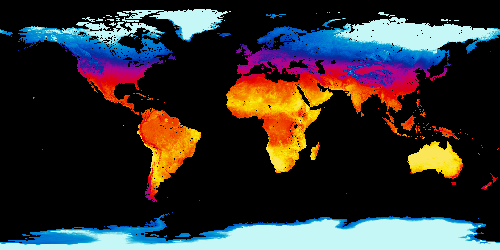

In [6]:
SedonaUtils.display_image(raster_df.selectExpr("RS_AsImage(raster, 500)"))

### Join based on raster predicates
Sedona 1.5.0 now supports join predicates between raster and geometry columns.

Below is a simple example that carves a small rectangle from the existing raster and attempts to join it with the original raster

In [7]:
(width, height) = sedona.sql("SELECT RS_Width(raster) as width, RS_Height(raster) as height from raster_table").first()
(p1X, p1Y) = sedona.sql(f"SELECT RS_RasterToWorldCoordX(raster, {width / 2}, {height / 2}) \
                  as pX, RS_RasterToWorldCoordY(raster, {width / 2}, {height / 2}) as pY from raster_table").first()
(p2X, p2Y) = sedona.sql(f"SELECT RS_RasterToWorldCoordX(raster, {(width / 2) + 2}, {height / 2}) \
                  as pX, RS_RasterToWorldCoordY(raster, {(width / 2) + 2}, {height / 2}) as pY from raster_table").first()
(p3X, p3Y) = sedona.sql(f"SELECT RS_RasterToWorldCoordX(raster, {width / 2}, {(height / 2) + 2}) \
                  as pX, RS_RasterToWorldCoordY(raster, {width / 2}, {(height / 2) + 2}) as pY from raster_table").first()
(p4X, p4Y) = sedona.sql(f"SELECT RS_RasterToWorldCoordX(raster, {(width / 2) + 2}, {(height / 2) + 2}) \
                  as pX, RS_RasterToWorldCoordY(raster, {(width / 2) + 2}, {(height / 2) + 2}) as pY from raster_table").first() 

In [8]:
geom_wkt = f"SRID={int(raster_srid)};POLYGON (({p1X} {p1Y}, {p2X} {p2Y}, {p3X} {p3Y}, {p4X} {p4Y}, {p1X} {p1Y}))"

In [9]:
geom_df = sedona.sql(f"SELECT ST_GeomFromEWKT('{geom_wkt}') as geom")
geom_df.createOrReplaceTempView("geom_table")

In [10]:
joined_df = sedona.sql("SELECT g.geom from raster_table r, geom_table g where RS_Intersects(r.raster, g.geom)")
joined_df.show()

+--------------------+
|                geom|
+--------------------+
|POLYGON ((-0.25 0...|
+--------------------+



### Interoperability between raster and vector data types
Sedona allows for conversions from raster to geometry and vice-versa. 

### Convert a raster to vector using convex hull
A convex hull geometry can be created out of a raster using [RS_ConvexHull](https://sedona.apache.org/1.5.0/api/sql/Raster-operators/#rs_convexhull)

Additionally, if a raster has noDataValue specified, and you wish to tighten the convexhull to exclude noDataValue boundaries, [RS_MinConvexHull](https://sedona.apache.org/1.5.0/api/sql/Raster-operators/#rs_minconvexhull) can be used.

In [11]:
raster_convex_hull = sedona.sql("SELECT RS_ConvexHull(raster) as convex_hull from raster_table")
raster_min_convex_hull = sedona.sql("SELECT RS_MinConvexHull(raster) as min_convex_hull from raster_table")
raster_convex_hull.show(truncate=False)
raster_min_convex_hull.show(truncate=False)

+-------------------------------------------------------+
|convex_hull                                            |
+-------------------------------------------------------+
|POLYGON ((-180 90, 180 90, 180 -90, -180 -90, -180 90))|
+-------------------------------------------------------+



+-------------------------------------------------------+
|min_convex_hull                                        |
+-------------------------------------------------------+
|POLYGON ((-180 90, 180 90, 180 -90, -180 -90, -180 90))|
+-------------------------------------------------------+



### Convert a geometry to raster (Rasterize a geometry)
A geometry can be converted to a raster using [RS_AsRaster](https://sedona.apache.org/1.5.0/api/sql/Raster-writer/#rs_asraster)

In [12]:
rasterized_geom_df = sedona.sql("SELECT RS_AsRaster(ST_GeomFromWKT('POLYGON((150 150, 220 260, 190 300, 300 220, 150 150))'), r.raster, 'b', 230) as rasterized_geom from raster_table r")
rasterized_geom_df.show()

24/05/22 17:59:36 WARN VectorToRasterProcess: coercing double feature values to float raster values


+--------------------+
|     rasterized_geom|
+--------------------+
|GridCoverage2D["g...|
+--------------------+



24/05/22 17:59:36 WARN VectorToRasterProcess: coercing double feature values to float raster values


,rasterized_geom
0,

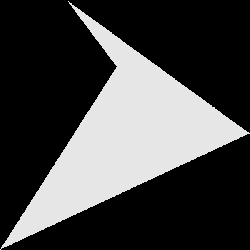

In [13]:
SedonaUtils.display_image(rasterized_geom_df.selectExpr("RS_AsImage(rasterized_geom, 250) as rasterized_geom"))

### Perform Map Algebra operations
Sedona provides two ways to perform [Map Algebra](https://sedona.apache.org/1.5.0/api/sql/Raster-map-algebra/) on rasters:
1. Using RS_MapAlgebra (preferred for simpler algebraic functions)
2. Using RS_BandAsArray and array based map algebra functions such as RS_Add, RS_Multiply (Useful for complex algebriac functions involving mutating each grid value differently.)

The following example illustrates how RS_MapAlgebra can be used. 
This example uses jiffle script to invert the colors of the above illustrated rasterized geometry.

In [14]:
raster_white_bg = rasterized_geom_df.selectExpr("RS_MapAlgebra(rasterized_geom, NULL, 'out[0] = rast[0] == 0 ? 230 : 0;') as raster")

24/05/22 17:59:37 WARN VectorToRasterProcess: coercing double feature values to float raster values
ANTLR Tool version 4.7.1 used for code generation does not match the current runtime version 4.9.3
ANTLR Runtime version 4.7.1 used for parser compilation does not match the current runtime version 4.9.3
ANTLR Tool version 4.7.1 used for code generation does not match the current runtime version 4.9.3
ANTLR Runtime version 4.7.1 used for parser compilation does not match the current runtime version 4.9.3


,resampled_raster
0,

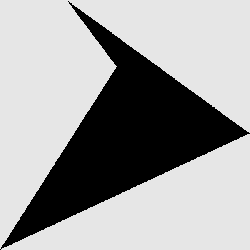

In [15]:
SedonaUtils.display_image(raster_white_bg.selectExpr("RS_AsImage(raster, 250) as resampled_raster"))

### Resample a raster.
Sedona 1.5.0 supports resampling a raster to different height/width or scale. It also supports changing the pivot of the raster.

Refer to [RS_Resample](https://sedona.apache.org/1.5.0/api/sql/Raster-operators/#rs_resample) documentation for more details.

This simple example changes the resolution of the loaded raster to 1000*1000

In [16]:
resampled_raster_df = sedona.sql("SELECT RS_Resample(raster, 1000, 1000, false, 'NearestNeighbor') as resampled_raster from raster_table")

,resampled_raster
0,

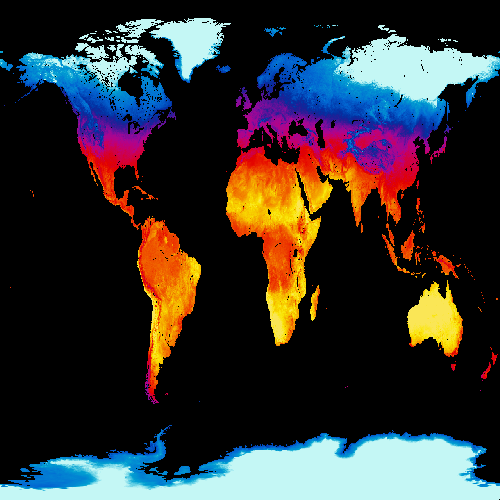

In [17]:
SedonaUtils.display_image(resampled_raster_df.selectExpr("RS_AsImage(resampled_raster, 500) as resampled_raster"))

In [18]:
resampled_raster_df.selectExpr("RS_MetaData(resampled_raster) as resampled_raster_metadata").show(truncate=False)

+------------------------------------------------------------------+
|resampled_raster_metadata                                         |
+------------------------------------------------------------------+
|[-180.0, 90.0, 1000.0, 1000.0, 0.36, -0.18, 0.0, 0.0, 4326.0, 1.0]|
+------------------------------------------------------------------+



In [19]:
# Load another raster for some more examples
elevation_raster_df = sedona.read.format('binaryFile').load('data/raster/test1.tiff')
elevation_raster_df.createOrReplaceTempView("elevation_raster_binary")

In [20]:
elevation_raster_df = sedona.sql("SELECT RS_FromGeoTiff(content) as raster from elevation_raster_binary")
elevation_raster_df.createOrReplaceTempView("elevation_raster")

### Access individual values from rasters
Sedona provides [RS_Value](https://sedona.apache.org/1.5.0/api/sql/Raster-operators/#rs_value) and [RS_Values](https://sedona.apache.org/1.5.0/api/sql/Raster-operators/#rs_values) that allow accessing raster values at given geometrical point(s).

The following example extracts raster values at specific geographical points.

In [21]:
point_wkt_1 = 'SRID=3857;POINT (-13095600.809482181 4021100.7487925636)'
point_wkt_2 = 'SRID=3857;POINT (-13095500.809482181 4021000.7487925636)'
point_df = sedona.sql("SELECT ST_GeomFromEWKT('{}') as point_1, ST_GeomFromEWKT('{}') as point_2".format(point_wkt_1, point_wkt_2))
point_df.createOrReplaceTempView("point_table")
test_df = sedona.sql("SELECT RS_Values(raster, Array(point_1, point_2)) as raster_values from elevation_raster, point_table")
test_df.show()

+--------------+
| raster_values|
+--------------+
|[115.0, 148.0]|
+--------------+



### Extract individual bands from rasters
[RS_BandAsArray](https://sedona.apache.org/1.5.0/api/sql/Raster-operators/#rs_bandasarray) can be used to extract entire band values from a given raster

In [22]:
band = elevation_raster_df.selectExpr("RS_BandAsArray(raster, 1)").first()[0]
print(band[500: 520],) #Print a part of a band as an array horizontally

[123.0, 107.0, 156.0, 173.0, 115.0, 82.0, 165.0, 222.0, 115.0, 82.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


### Visualize Raster MBRs

In [23]:
# Convert raster to its convex hull and transform it to EPSG:4326 to be able to visualize
raster_mbr_df = elevation_raster_df.selectExpr("ST_Transform(RS_ConvexHull(raster), 'EPSG:3857', 'EPSG:4326') as raster_mbr")

In [ ]:
sedona_kepler_map_elevation = SedonaKepler.create_map(df=raster_mbr_df, name='RasterMBR')
sedona_kepler_map_elevation